In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import * 
from tqdm import tqdm

from numpy import sin, linspace, array, pi, sqrt 

In [2]:
#conda clean --all

### Hamiltonian For this fully coupled syestem:
\begin{equation} \label{eq:Heff_c2} 
\Large \hat{H}_{Hyb}=\omega_{c}\hat{a}^\dagger \hat{a}+ \frac{\omega_{a}}{2}\hat{\sigma}_{z}+\omega_m \hat{b}^\dagger \hat{b} \\
\Large \;\;\;\;\;\;\;\;\;\;\; ig_{ac}(\hat{\sigma}_{+}\hat{a}-\hat{\sigma}_{-}\hat{a}^\dagger) -
 g_{cm}\hat{a}^\dagger \hat{a}(\hat{b}+\hat{b}^\dagger) -
 g_{am} \hat{\sigma}_{z}(\hat{b}+\hat{b}^\dagger)
\end{equation}

## $H_{Hyb}$
Fig. 3b 

Fig. 4b
I am testing N start from 7

N= 5

N = 9   next time! 5/7/2021

N = 11  10/7

.......

Time sample


In [3]:
def calculate_H(w_m, w_a, w_L, g_cm, g_am, g_ac, gamma, kappa, n_th, F_L):
    N = 5                  # number of cavity fock states
    M = 12                  # number of phonon fock states 
    
    #alpha = g_am * (1-(g_ac/Delta_aL)**2) 
    #alpha = - (g_eff-g_cm)/2.

    a = tensor(destroy(N), qeye(M), qeye(2))
    b = tensor(qeye(N), destroy(M), qeye(2))
    sigma_z = tensor(qeye(N), qeye(M), sigmaz())
    sigma_p = tensor(qeye(N), qeye(M), sigmap())  # raising and lowering ops for atom
    sigma_m = tensor(qeye(N), qeye(M), sigmam())
    
    """ 
    a = tensor(destroy(N), qeye(M), qeye(2))
    b = tensor(qeye(N), destroy(M), qeye(2))
    sigma_m = tensor(qeye(N), qeye(M), destroy(2))
    sigma_p = sigma_m.dag()
    sigma_z = sigma_p * sigma_m
    """
    n_a = a.dag() * a 
    n_b = b.dag() * b
    
    gamma_a = gamma                           # decay rate of Atom
    c_ops = []
    rate = kappa                              # kappa is cavity decay rate
    if rate > 0.0 : 
        c_ops.append(a * sqrt(rate))
    rate = n_th * gamma                       # gamma is mechanical resonator
    if rate > 0.0: 
        c_ops.append(b.dag() * sqrt(rate))
    rate = (n_th+1) * gamma
    if rate > 0.0 : 
        c_ops.append(b * sqrt(rate))

    rate = gamma_a
    if rate > 0.0 : 
        c_ops.append(sigma_m * sqrt(rate))
############ H  ################## 
    w_c = w_L
    Delta = w_L - w_c
    Delta_aL = w_a - w_L
    
    H = -(Delta)* n_a + 0.5 * Delta_aL * sigma_z + w_m * n_b + 1j* g_ac * (a* sigma_p - a.dag()* sigma_m) \
       - g_am * (sigma_z + 1) * (b + b.dag()) - g_cm * (b + b.dag()) * n_a + 1j* F_L * (a.dag()- a)
    
    # H0: at resonance and for g=0
    H0 = 0.5 * Delta_aL * sigma_z + w_m * n_b  + 1j* F_L * (a.dag()- a)

    return H, H0, c_ops, a, N, M

### Parameters

In [5]:
Set = 2               ##### set of Parametrs    

if (Set==1):
    w_a  = 1000      #[ 1500 ]   [1052  ]
    w_L  =  1500 
    g_am = 50         #[  50   ]  [.54    ] 
    g_ac =  50   
elif Set==2:
    w_a  = 15000      #[ 15000 ]  [10520  ]
    w_L =  10000 
    g_am = 50      #[  50   ]   [.54     ]
    g_ac =  500   

w_m  = 1                       # mechanical frequency
gamma    = w_m/20.             ## gamma is decay for mechanical resonator 
g_cm = 0.001 * w_m  
n_th_i   = [0, 1, 0 ]                              
kappa_i  = [2. * w_m, w_m/2., w_m/2.]     # kappa is cavity decay rate


In [6]:
#Delta_aL = w_a - w_L
#w_c  = w_L +(g_ac**2)/Delta_aL

#alpha = g_am * (1-(g_ac/Delta_aL)**2) 
#shift = g_ac**2/Delta_aL
#g_eff = g_cm + 2 * g_am * (g_ac/Delta_aL)**2
#g_eff
#alpha
#shift

### Save data

In [7]:
#opt = Odeoptions(nsteps=2000) # allow extra time-steps 

opt = Options(nsteps=10000)
tlist = np.linspace(0, 100, 20000)

#wlist = np.linspace(-7, 8, 1000) * w_m
xplot = []                                 #######=====###########====####
s = len(n_th_i) + 1
plot_test  = np.zeros((len(tlist),s), dtype = complex)       ############tlist
#plot4a  = np.zeros((len(tlist),s))                          ############wlist
mean      = np.zeros((len(tlist),s), dtype = complex)
correlat  = np.zeros((len(tlist),s), dtype = complex)


In [8]:
solvers = ['direct','power','eigen','iterative-gmres','iterative-bicgstab']  # methods 
# only for ['iterative-gmres','iterative-bicgstab']---  use_rcm = True
use_rcm = False

#Delta_aL = w_a - w_L 
#g_eff = g_cm + 2 * g_am * (g_ac/Delta_aL)**2 

for i in tqdm([1]): #tqdm([0,1,2]): 
    kappa = kappa_i[i]
    n_th  = n_th_i[i] 
    F_L   = sqrt(kappa) * 0.01   ###0.01   # Laser amplitude
        
    H, H0, c_ops, a, N, M = calculate_H(w_m, w_a, w_L, g_cm, g_am, g_ac, gamma, kappa, n_th, F_L)    
    #rho0 = tensor(basis(N,1),basis(M,1), basis(2,0))     # basis(2,0) qubit in ground state
    
    ### n_0    
    #rho0     = steadystate(H0, c_ops, method=solvers[2] , tol=1e-15) ######
    

    #n0       = mesolve(H0, rho0, tlist, c_ops, [a.dag() * a]).expect[0]  #, options=opt
    #n_0      = n0[-1]    
    n_0 = 4 * (F_L/kappa)**2        # alternative way for n_0
   
    ##########################  # calculate |<a(t)>|^2
    rho      = steadystate(H, c_ops, method=solvers[2] , tol=1e-15)
    n        = mesolve(H, rho, tlist, c_ops, [a], options= opt).expect[0]
    mean_a_t = np.abs(n)**2 
    mean[: , i]  = mean_a_t
        
    #corr      = correlation_ss(H, tlist, c_ops, a.dag(), a) ##### solver='me'
    corr      = correlation_2op_1t(H, rho , tlist, c_ops, a.dag(), a, options= opt)
    correlat[: , i]  = corr

    spect_tot = corr - mean_a_t                             #### to substract constantant derive peak 
    #wlist, spec1 = spectrum_correlation_fft(tlist, spect_tot) 

    ##########################
    #spec = spectrum(H, wlist, c_ops, a.dag(), a)               ##### needs a huge storage!
    ########################
    #### save data 
    plot_test[: , 0] = tlist        #wlist
    plot_test[: , i] = spect_tot
    #xplot = wlist                             ###########
    #pllot3aa[: , i] = spec/n_0                 ############
    #plot4a[: , i] = spec1/n_0                 ############

100%|██████████| 1/1 [1:07:15<00:00, 4035.11s/it]


C:\Users\Ahmad\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, ' $H_{hyb}$: $\\langle a(t)^ \\dagger a(0)  \\rangle - |\\langle a(t) \\rangle|^2$')

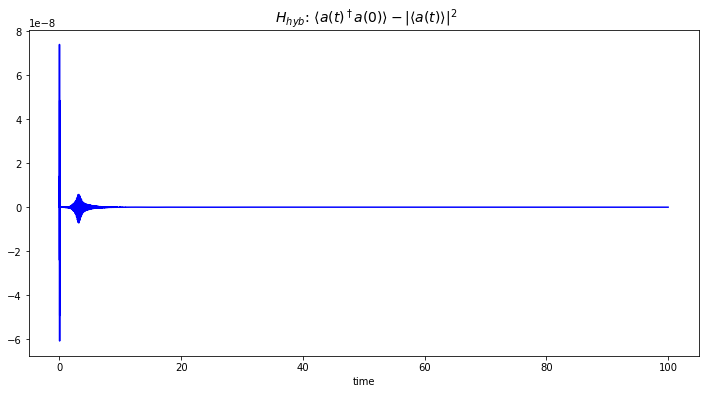

In [9]:
# t steps= 30000
fig, ax = plt.subplots(1, 1, figsize=(12,6))   # , sharex=True

ax.plot(plot_test[:,0], plot_test[:, 1], 'b', label=r'First-order coherence function $g^{(1)}(t)$')
#ax[1].plot(tlist, np.real(n),  'r', label=r'occupation number $n(t)$')
#ax[0].legend()
#ax[1].legend()
ax.set_xlabel(r'time');
#ax.set_xlim([0,1]) 
ax.set_title(r' $H_{hyb}$: $\langle a(t)^ \dagger a(0)  \rangle - |\langle a(t) \rangle|^2$', fontsize= 14)     
#plt.savefig("Correlation-n2_H_hyb_Zoom.pdf", dpi=150)

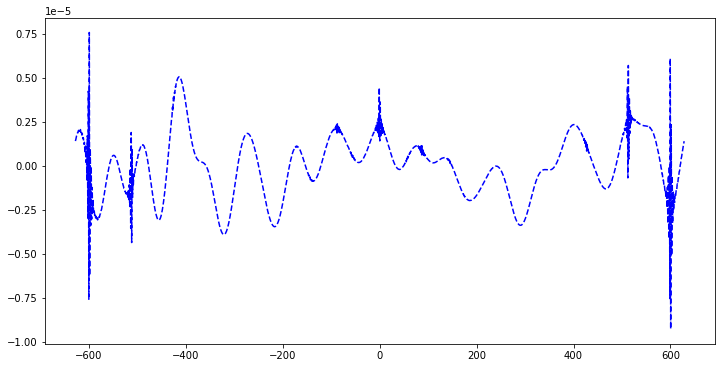

In [10]:
# t list= 30000
wlist, spec1 = spectrum_correlation_fft(tlist, spect_tot) 
n_0 = 4 * (F_L/kappa)**2        # alternative way for n_0
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,6))
linestyle =['--','--','-']
color=['black', 'r', 'b']
ax.plot(wlist / w_m, spec1/n_0 , linestyle =linestyle[1], color=color[2])
#ax.set_xlim([-307,57]) 

C:\Users\Ahmad\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, ' $H_{hyb}$: $\\langle a(t)^ \\dagger a(0)  \\rangle - |\\langle a(t) \\rangle|^2$')

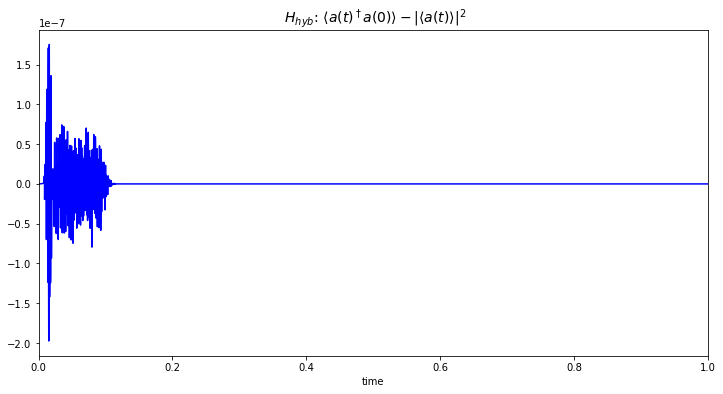

In [7]:
# t steps= 30000
fig, ax = plt.subplots(1, 1, figsize=(12,6))   # , sharex=True

ax.plot(plot_test[:,0], plot_test[:, 1], 'b', label=r'First-order coherence function $g^{(1)}(t)$')
#ax[1].plot(tlist, np.real(n),  'r', label=r'occupation number $n(t)$')
#ax[0].legend()
#ax[1].legend()
ax.set_xlabel(r'time');
ax.set_xlim([0,1]) 
ax.set_title(r' $H_{hyb}$: $\langle a(t)^ \dagger a(0)  \rangle - |\langle a(t) \rangle|^2$', fontsize= 14)     
#plt.savefig("Correlation-n2_H_hyb_Zoom.pdf", dpi=150)

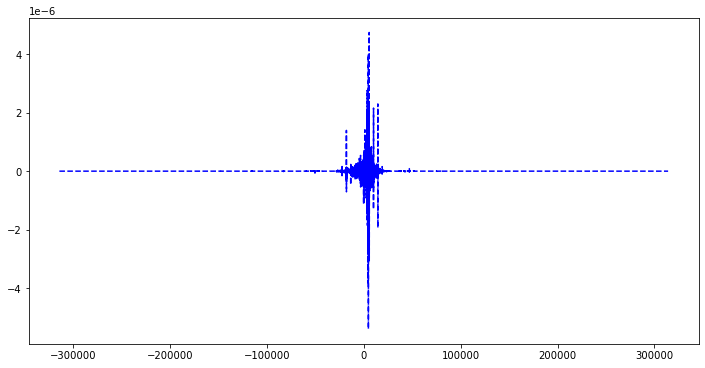

In [12]:
# t list= 30000
wlist, spec1 = spectrum_correlation_fft(tlist, spect_tot) 
n_0 = 4 * (F_L/kappa)**2        # alternative way for n_0
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,6))
linestyle =['--','--','-']
color=['black', 'r', 'b']
ax.plot(wlist / w_m, spec1/n_0 , linestyle =linestyle[1], color=color[2])
#ax.set_xlim([-307,57]) 

(-150.0, 150.0)

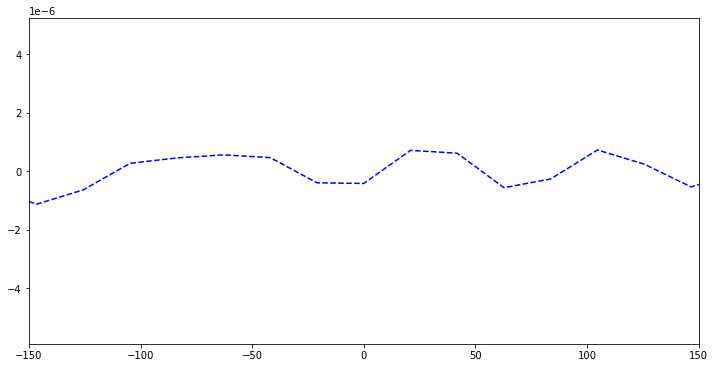

In [21]:
# t list= 30000
wlist, spec1 = spectrum_correlation_fft(tlist, spect_tot) 
n_0 = 4 * (F_L/kappa)**2        # alternative way for n_0
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,6))
linestyle =['--','--','-']
color=['black', 'r', 'b']
ax.plot(wlist / w_m, spec1/n_0 , linestyle =linestyle[1], color=color[2])
ax.set_xlim([-150,150]) 

Text(0.5, 1.0, ' $H_{hyb}$: $\\langle a(t)^ \\dagger a(0)  \\rangle - |\\langle a(t) \\rangle|^2$')

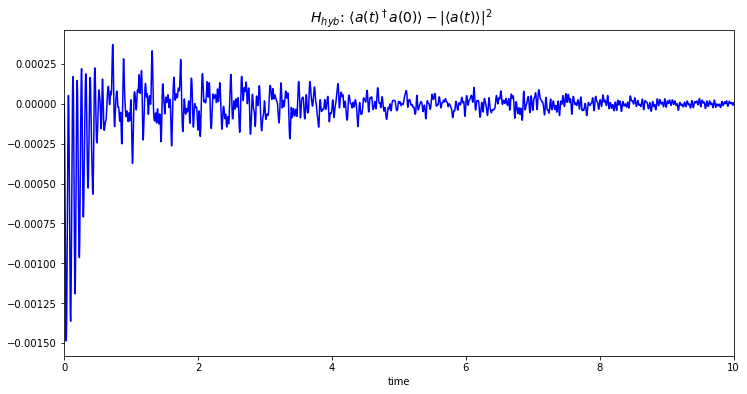

In [8]:
# N= 11
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,6))

ax.plot(plot_test[:,0], plot_test[:, 1], 'b', label=r'First-order coherence function $g^{(1)}(t)$')
#ax[1].plot(tlist, np.real(n),  'r', label=r'occupation number $n(t)$')
#ax[0].legend()
#ax[1].legend()
ax.set_xlabel(r'time');
ax.set_xlim([0,10]) 
ax.set_title(r' $H_{hyb}$: $\langle a(t)^ \dagger a(0)  \rangle - |\langle a(t) \rangle|^2$', fontsize= 14)     
#plt.savefig("Correlation-n2_H_hyb_Zoom.pdf", dpi=150)

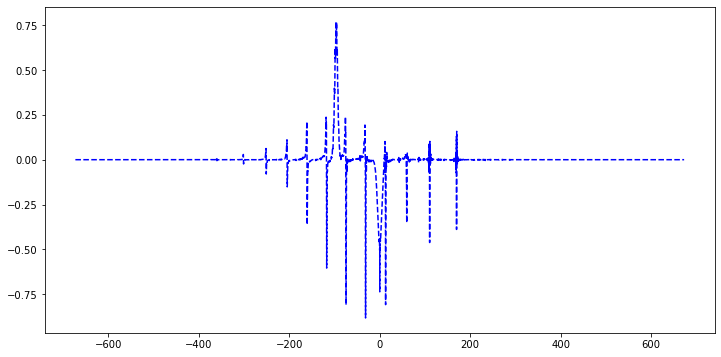

In [9]:
# N = 11
wlist, spec1 = spectrum_correlation_fft(tlist, spect_tot) 
n_0 = 4 * (F_L/kappa)**2        # alternative way for n_0
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,6))
linestyle =['--','--','-']
color=['black', 'r', 'b']
ax.plot(wlist / w_m, spec1/n_0 , linestyle =linestyle[1], color=color[2])
#ax.set_xlim([-117,7]) 

Text(0.5, 1.0, ' $H_{hyb}$: $\\langle a(t)^ \\dagger a(0)  \\rangle - |\\langle a(t) \\rangle|^2$')

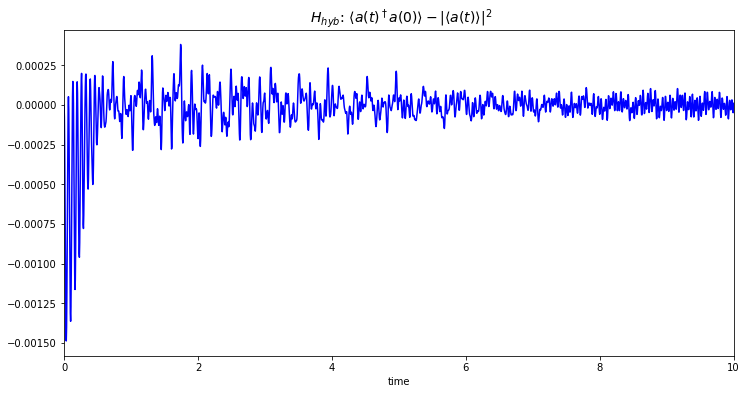

In [12]:
# N= 9
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,6))

ax.plot(plot_test[:,0], plot_test[:, 1], 'b', label=r'First-order coherence function $g^{(1)}(t)$')
#ax[1].plot(tlist, np.real(n),  'r', label=r'occupation number $n(t)$')
#ax[0].legend()
#ax[1].legend()
ax.set_xlabel(r'time');
ax.set_xlim([0,10]) 
ax.set_title(r' $H_{hyb}$: $\langle a(t)^ \dagger a(0)  \rangle - |\langle a(t) \rangle|^2$', fontsize= 14)     
#plt.savefig("Correlation-n2_H_hyb_Zoom.pdf", dpi=150)

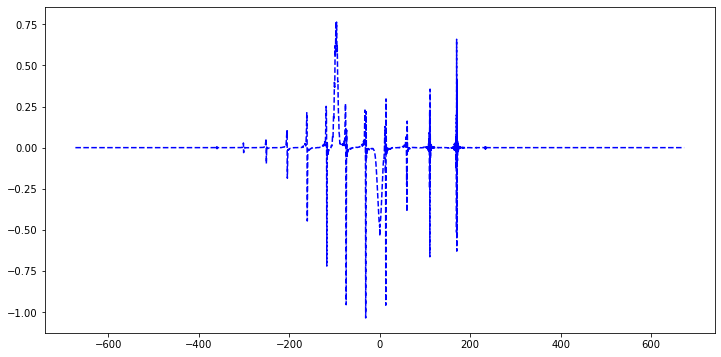

In [15]:
# N = 9
wlist, spec1 = spectrum_correlation_fft(tlist, spect_tot) 
n_0 = 4 * (F_L/kappa)**2        # alternative way for n_0
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,6))
linestyle =['--','--','-']
color=['black', 'r', 'b']
ax.plot(wlist / w_m, spec1/n_0 , linestyle =linestyle[1], color=color[2])
#ax.set_xlim([-117,7]) 

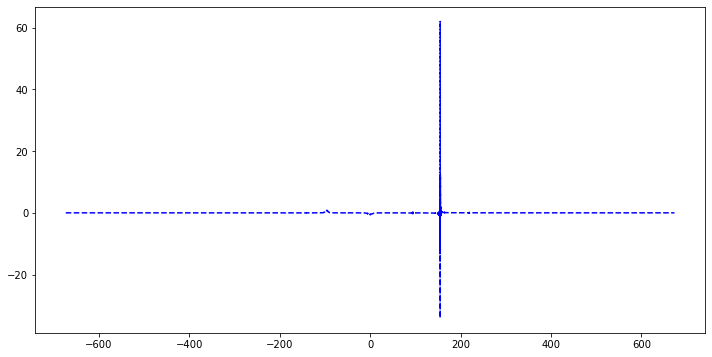

In [32]:
wlist, spec1 = spectrum_correlation_fft(tlist, spect_tot) 
n_0 = 4 * (F_L/kappa)**2        # alternative way for n_0
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,6))
linestyle =['--','--','-']
color=['black', 'r', 'b']
ax.plot(wlist / w_m, spec1/n_0 , linestyle =linestyle[1], color=color[2])
#ax.set_xlim([-17,7]) 

Text(0.5, 1.0, ' $H_{hyb}$: $\\langle a(t)^ \\dagger a(0)  \\rangle - |\\langle a(t) \\rangle|^2$')

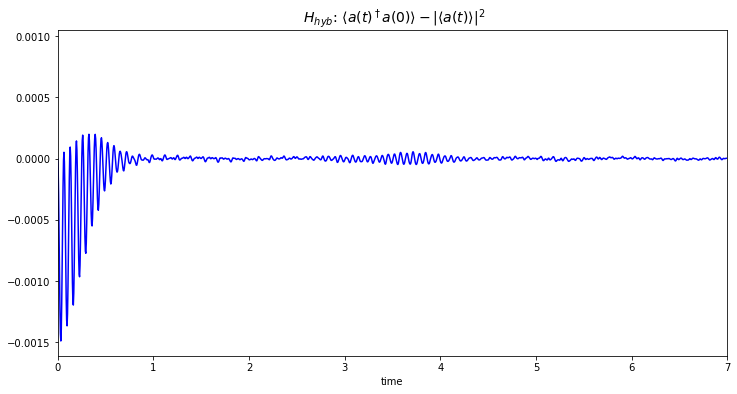

In [33]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,6))

ax.plot(plot_test[:,0], plot_test[:, 1], 'b', label=r'First-order coherence function $g^{(1)}(t)$')
#ax[1].plot(tlist, np.real(n),  'r', label=r'occupation number $n(t)$')
#ax[0].legend()
#ax[1].legend()
ax.set_xlabel(r'time');
ax.set_xlim([0,7]) 
ax.set_title(r' $H_{hyb}$: $\langle a(t)^ \dagger a(0)  \rangle - |\langle a(t) \rangle|^2$', fontsize= 14)     
#plt.savefig("Correlation-n2_H_hyb_Zoom.pdf", dpi=150)

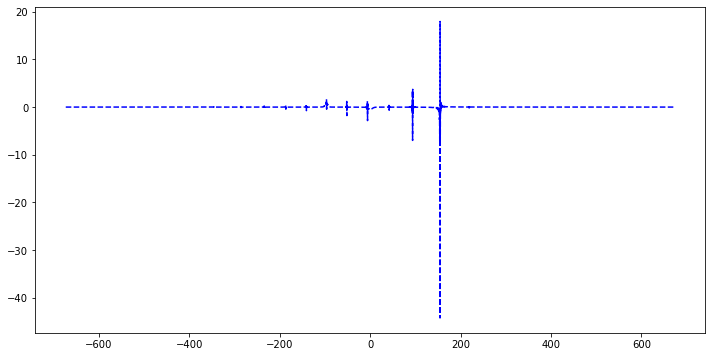

In [26]:
wlist, spec1 = spectrum_correlation_fft(tlist, spect_tot) 
n_0 = 4 * (F_L/kappa)**2        # alternative way for n_0
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,6))
linestyle =['--','--','-']
color=['black', 'r', 'b']
ax.plot(wlist / w_m, spec1/n_0 , linestyle =linestyle[1], color=color[2])
#ax.set_xlim([-17,7]) 

Text(0.5, 1.0, ' $H_{hyb}$: $\\langle a(t)^ \\dagger a(0)  \\rangle - |\\langle a(t) \\rangle|^2$')

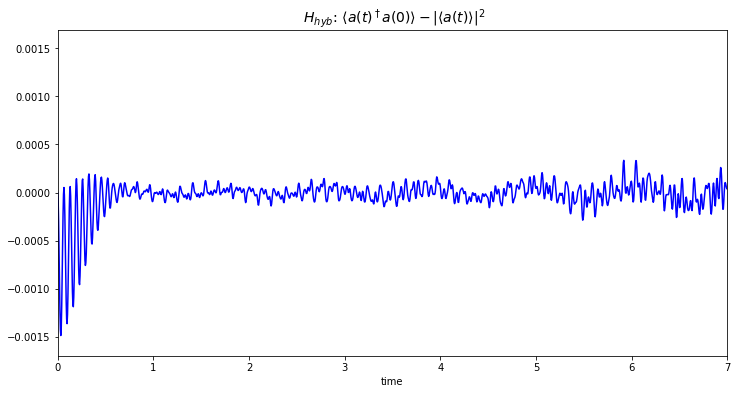

In [19]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,6))

ax.plot(plot_test[:,0], plot_test[:, 1], 'b', label=r'First-order coherence function $g^{(1)}(t)$')
#ax[1].plot(tlist, np.real(n),  'r', label=r'occupation number $n(t)$')
#ax[0].legend()
#ax[1].legend()
ax.set_xlabel(r'time');
ax.set_xlim([0,7]) 
ax.set_title(r' $H_{hyb}$: $\langle a(t)^ \dagger a(0)  \rangle - |\langle a(t) \rangle|^2$', fontsize= 14)     
#plt.savefig("Correlation-n2_H_hyb_Zoom.pdf", dpi=150)

### Figure

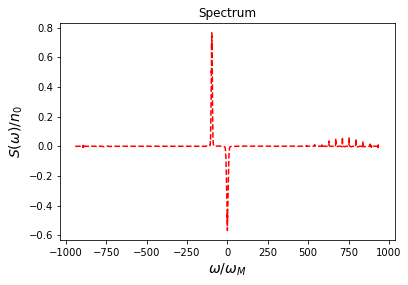

In [17]:
fig, ax= plt.subplots(1,1,figsize=(6,4))

linestyle =['--','--','-']
color=['black', 'r', 'b']


   
ax.plot(wlist / w_m, spec1/n_0 , linestyle =linestyle[i], color=color[i])  # /n_0    
ax.set_xlabel(r'$\omega/ \omega_M $', fontsize=14)
ax.set_ylabel(r'$ S(\omega) /n_0 $', fontsize=14)    # (r'$ e $',fontsize=16,color='red')
ax.set_title('Spectrum')
#ax.set_xlim([-200*w_m,55*w_m])
#ax.set_ylim([0,.05])   # ([0,max(spec)])


plt.savefig("Spectrum_hyb_4b15000.pdf", dpi=150)
plt.show()

C:\Users\Ahmad\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


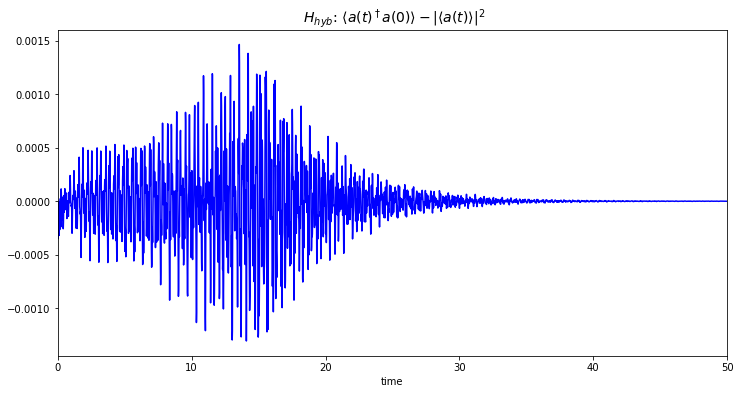

In [114]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,6))

ax.plot(tlist, spect_tot, 'b', label=r'First-order coherence function $g^{(1)}(t)$')
#ax[1].plot(tlist, np.real(n),  'r', label=r'occupation number $n(t)$')
#ax[0].legend()
#ax[1].legend()
ax.set_xlabel(r'time');
ax.set_title(r' $H_{hyb}$: $\langle a(t)^ \dagger a(0)  \rangle - |\langle a(t) \rangle|^2$', fontsize= 14)    
ax.set_xlim([0,50]) 

plt.savefig("Correlation-n2_H_hyb.pdf", dpi=150)

C:\Users\Ahmad\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


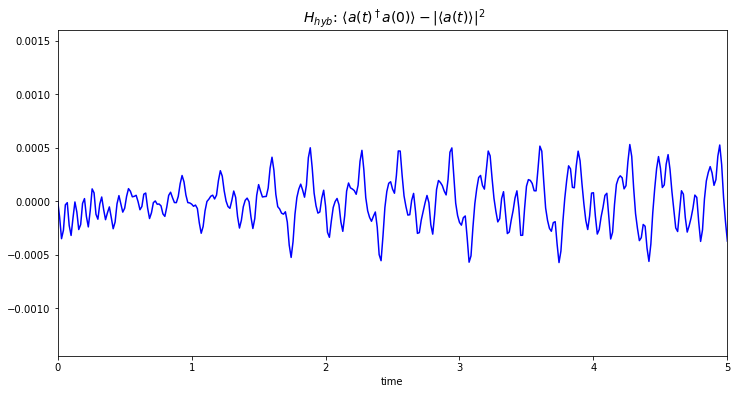

In [113]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,6))

ax.plot(tlist, spect_tot, 'b', label=r'First-order coherence function $g^{(1)}(t)$')
#ax[1].plot(tlist, np.real(n),  'r', label=r'occupation number $n(t)$')
#ax[0].legend()
#ax[1].legend()
ax.set_xlabel(r'time');
ax.set_xlim([0,5]) 
ax.set_title(r' $H_{hyb}$: $\langle a(t)^ \dagger a(0)  \rangle - |\langle a(t) \rangle|^2$', fontsize= 14)     
plt.savefig("Correlation-n2_H_hyb_Zoom.pdf", dpi=150)

###  Dynamics of an initially excited cavity

In [9]:
n_th_i   = [0, 1, 0 ]                              
kappa_i  = [2. * w_m, w_m/2., w_m/2.]     # kappa is cavity decay rate
kappa = kappa_i[1]
n_th = n_th_i[1]
F_L   = sqrt(kappa) * 0.01

N, M, H, H0, c_ops, a, b = calculate_H( w_m, w_a,w_L , g_cm, g_am, g_ac, g_eff, gamma, kappa, n_th, F_L)

opt = Options(nsteps=8000)
tlist = np.linspace(0, 20, 8000)     

sigma_m = tensor(qeye(N), qeye(M), destroy(2))
sigma_p = sigma_m.dag()
rho0 = tensor(basis(N,1),basis(M,1), basis(2,0))     # basis(2,0) qubit in ground state
n_a = a.dag() * a 
n_b = b.dag() * b
n_q = sigma_p * sigma_m

output = mesolve(H, rho0, tlist, c_ops, [n_a, n_b, n_q ], options= opt)

In [10]:
n = output.expect[0]

G1 = correlation(H, rho0, None, tlist, c_ops, a.dag(), a)


C:\Users\Ahmad\Anaconda3\lib\site-packages\qutip\correlation.py:748: FutureWarning: correlation() now legacy, please use correlation_2op_2t()
  FutureWarning)


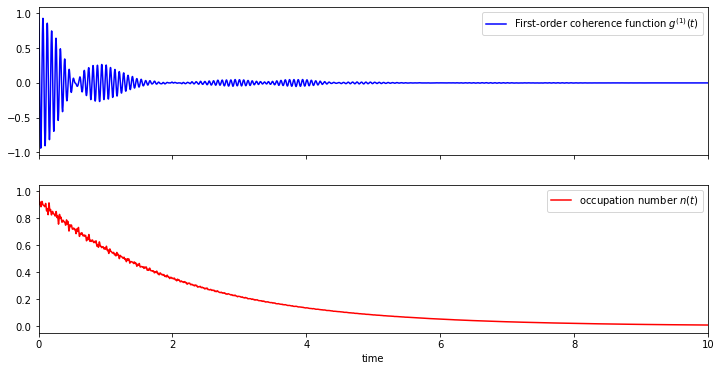

In [11]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,6))

ax[0].plot(tlist, np.real(G1), 'b', label=r'First-order coherence function $g^{(1)}(t)$')
ax[1].plot(tlist, np.real(n),  'r', label=r'occupation number $n(t)$')
ax[0].legend()
ax[1].legend()
ax[1].set_xlabel(r'time');
ax[0].set_xlim([0,10]) 

plt.savefig("Correlation15000_exitQubit.pdf", dpi=150)

In [14]:
corr_steady = correlation_2op_1t(H, None, tlist, c_ops, a.dag(), a, options= opt)

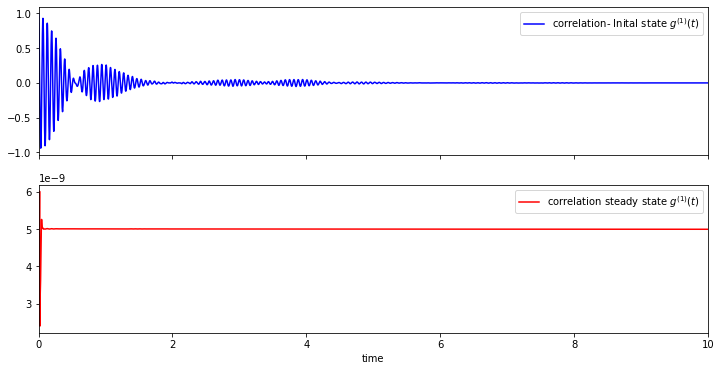

In [19]:
#g1 = G1 / sqrt(n[0] * n)
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,6))

ax[0].plot(tlist, np.real(G1), 'b', label=r'correlation- Inital state $g^{(1)}(t)$')
ax[1].plot(tlist, np.real(corr_steady),  'r', label=r'correlation steady state $g^{(1)}(t)$')
ax[0].legend()
ax[1].legend()
ax[1].set_xlabel(r'time');
ax[0].set_xlim([0,10]) 

plt.savefig("Correlation_n_InitalState_and_SteadyState.pdf", dpi=150)

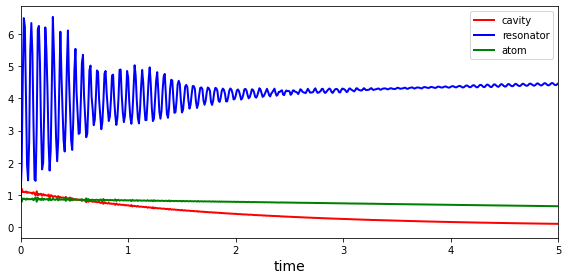

In [39]:
#qubit in excited state
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,4))

ax.plot(tlist, np.real(output.expect[0]), 'r', linewidth=2, label="cavity")
ax.plot(tlist, np.real(output.expect[1]), 'b', linewidth=2, label="resonator")
ax.plot(tlist, np.real(output.expect[2]), 'g', linewidth=2, label="atom")
ax.legend(loc=0)

ax.set_xlim([0,5]) 
ax.set_xlabel('time', fontsize=14)
plt.savefig("Dynamics15000_ExtQubit.pdf", dpi=150)

fig.tight_layout()

### Correlation function

In [54]:
n = output.expect[0]
G1 = correlation(H, rho0, None, tlist, c_ops, a.dag(), a)
g1 = G1 / sqrt(n[0] * n)

C:\Users\Ahmad\Anaconda3\lib\site-packages\qutip\correlation.py:748: FutureWarning: correlation() now legacy, please use correlation_2op_2t()
  FutureWarning)


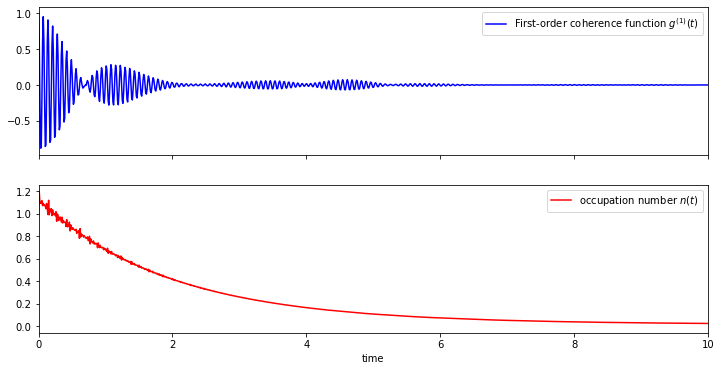

In [50]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,6))

ax[0].plot(tlist, np.real(g1), 'b', label=r'First-order coherence function $g^{(1)}(t)$')
ax[1].plot(tlist, np.real(n),  'r', label=r'occupation number $n(t)$')
ax[0].legend()
ax[1].legend()
ax[1].set_xlabel(r'time');
ax[0].set_xlim([0,10]) 

plt.savefig("Correlation15000_exitQubit.pdf", dpi=150)


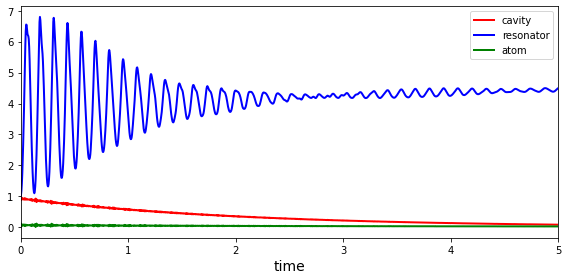

In [53]:
#qubit in ground state
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,4))

ax.plot(tlist, np.real(output.expect[0]), 'r', linewidth=2, label="cavity")
ax.plot(tlist, np.real(output.expect[1]), 'b', linewidth=2, label="resonator")
ax.plot(tlist, np.real(output.expect[2]), 'g', linewidth=2, label="atom")
ax.legend(loc=0)

ax.set_xlim([0,5]) 
ax.set_xlabel('time', fontsize=14)
plt.savefig("Dynamics15000_GroundQubit.pdf", dpi=150)

fig.tight_layout()

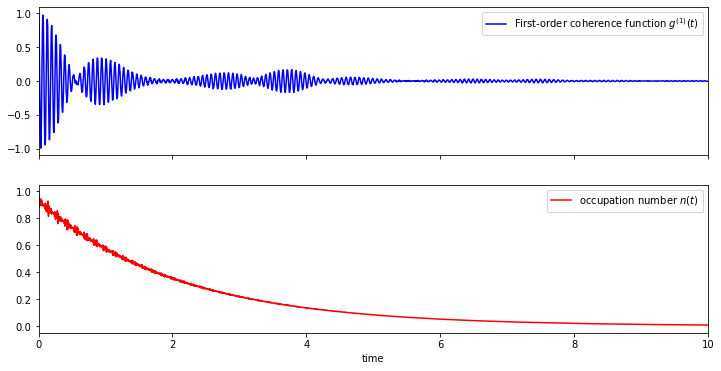

In [57]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,6))

ax[0].plot(tlist, np.real(g1), 'b', label=r'First-order coherence function $g^{(1)}(t)$')
ax[1].plot(tlist, np.real(n),  'r', label=r'occupation number $n(t)$')
ax[0].legend()
ax[1].legend()
ax[1].set_xlabel(r'time');
ax[0].set_xlim([0,10]) 

plt.savefig("Correlation15000_groundQubit.pdf", dpi=150)

In [34]:
N= 2
M= 2
sigma_m = tensor(qeye(N), qeye(M), destroy(2))
sigma_p = sigma_m.dag()
ii = sigma_m * tensor(basis(N,1),basis(M,1), basis(2,0))
ii

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [144]:
#psi0 = tensor(basis(N,0), basis(2,1))    # start with an excited atom
H, a, sigma_m, c_ops = calculate_H(N, w_a, w_c,  g_ac, gamma, kappa,  n_th, use_rwa)

opt = Options(nsteps=15000)  #opt=Options(nsteps=1500)
#output = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sigma_m.dag() * sigma_m], options= opt)

In [147]:
rho      = steadystate(H, c_ops, tol=1e-12)     #  method=solvers[0] ,
#n        = mesolve(H, rho, tlist, c_ops, [a], options= opt).expect[0]

In [153]:
G1 = correlation_ss(H, tlist, c_ops, a.dag(), a, options= opt)

C:\Users\Ahmad\Anaconda3\lib\site-packages\qutip\correlation.py:665: FutureWarning: correlation_ss() now legacy, please use correlation_2op_1t() withinitial state as None
  "initial state as None", FutureWarning)


In [131]:
mean_a_t = np.abs(n)**2

In [112]:
n_c = output.expect[0]
n_a = output.expect[1]

### Figure

In [152]:
#mean_a_t
#rho

(0.0, 3.0)

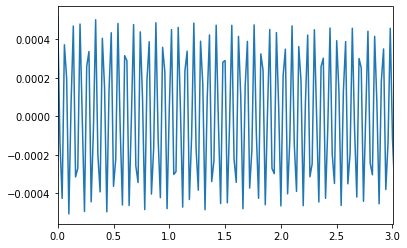

In [155]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
#plt.plot(tlist, n_c)
#plt.plot(tlist, n_a)
#plt.plot(tlist, mean_a_t)
plt.plot(tlist, np.real(G1))
ax.set_xlim([0,3])